#### Simulated foraging
Based on heuristics described in the proposal, I explore the viability, performance, and appearance of different combinations of heuristics influencing coconut acquisition strategy. In this notebook, I provide the code used to assemble and run the simulations in python. 

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000002582D6D1FD0>>
Traceback (most recent call last):
  File "c:\Users\lcwat\coconuts\coconuts_thesis\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 796, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
  File "C:\Users\lcwat\AppData\Local\Programs\Python\Python313\Lib\threading.py", line 1477, in enumerate
    def enumerate():
KeyboardInterrupt: 


In [3]:
# load coconut location data for each level
all_coco_location_data = pd.read_csv(
    "../../data/level_arrangements/all_levels_arrangements.csv"
)
all_coco_location_data.iloc[0:5]

,obj_ID,point_value,x,y,level
0,1,2,15.0,23.5,1
1,2,2,15.0,20.0,1
2,3,2,10.0,20.0,1
3,4,2,20.0,20.0,1
4,5,2,12.5,17.5,1


To simulate heuristic tactics, available coconuts are evaluated according to a rule. Nearest neighbor evaluation maximizes inverse distance from a forager's current location and a harvestable coconut. Turning angle minimization minimizes the turning angle (approach angle minus the exit angle) to a harvestable coconut. Clustering maximizes the value of a harvestable coconut according to how close surrounding harvestable coconuts are to that coconut. 

#### Simulation
With the evaluation methods established (see src/foraging_funs.py for code), I can implement them into an agent-based simulation where agents are specified to use different combinations of heuristics with different weightings for their foraging strategies. The simulation will output their foraging record (which coconuts were collected when) for analysis and visualization. To begin my exploration in my initial proposal, I started with a simulation of pure strategies pulling weights from a normal distribution above 0 and fixing point value weights to 1. With this, I can theoretically parse the differences in outcomes like performance, route routineness/traplining, and route geometry. 

In [4]:
# init distance matrices
%run ../src/foraging_funs.py
d = create_distance_matrices(all_coco_location_data)

In [ ]:
# simulating forages by agents valuing heuristics differently
def simulate_forages(
    n_agents=100, lvl_obj_locs=all_coco_location_data, lvl_dist_ms=d,
    wt_dist_par=[0, 1]
):

    # strats
    strat_list = ['nn', 'ta', 'clst']

    # run through each foraging strategy
    for strat_i in range(0, len(strat_list)):

        # loop through agent pool
        for agent_no in tqdm(range(n_agents)):

            # assign unique weights
            weights = np.random.normal(wt_dist_par[0], wt_dist_par[1], 4)
            # fix points to 1
            weights[3] = 1

            if strat_list[strat_i] == 'nn':
                weights[[1, 2]] = 0
            if strat_list[strat_i] == 'ta':
                weights[[0, 2]] = 0
            if strat_list[strat_i] == 'clst':
                weights[[0, 1]] = 0

            # loop through levels
            for level_no in range(10):

                # set the level locations and dist matrix to use
                lvl = lvl_obj_locs[lvl_obj_locs.level == level_no+1]
                lvl_m = lvl_dist_ms[level_no]

                # let agent play the level and record results
                forage_results = run_foraging_agent(
                    lvl_coco_locs=lvl, lvl_dist_m=lvl_m, weights=weights,
                    rps=[0, .01], clust_neighbors=2
                )

                # add level and agent identifiers
                info_dict = {
                    'strategy': [strat_list[strat_i] for i in range(len(forage_results))],
                    'forager': [agent_no for i in range(len(forage_results))],
                    'level': [level_no+1 for i in range(len(forage_results))]
                }

                # add to df
                forage_results = forage_results.assign(**info_dict)

                # if first run, init the df
                if (strat_i == 0) and (agent_no == 0) and (level_no == 0):
                    # create csv file
                    forage_results.to_csv(
                        '../../data/simulation/runs/pure_strats/simul_weighted_forages_10_20_25.csv',
                        index=False
                    )
                # add to complete file
                else:
                    forage_results.to_csv(
                        '../../data/simulation/runs/pure_strats/simul_weighted_forages_10_20_25.csv',
                        mode='a', index=False, header=False
                    )

                # wipe from memory
                del forage_results

    print('Completed all forages.')

In [ ]:
simulate_forages(n_agents=1, wt_dist_par=[2, 1])

100%|██████████| 1/1 [00:22<00:00, 22.07s/it]

Completed all forages.


: 

: 

In [ ]:
# check out data
runs = pd.read_csv(
    '../../data/simulation/runs/pure_strats/simul_weighted_forages_10_20_25.csv')

pd.head(runs)

: 

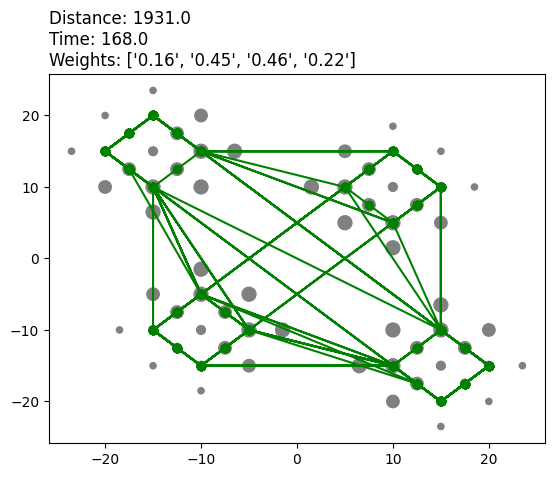

In [ ]:
# set level here
l = 6

lvl = all_coco_location_data[all_coco_location_data.level == l]

lvl_m = d[l-1]

weights = np.random.normal(.3, .15, 4)

# run one forage and view results
%run ../src/foraging_funs.py
forage_df = run_foraging_agent(

    lvl_coco_locs=lvl, lvl_dist_m=lvl_m, weights=weights, rps=[0, .01], clust_neighbors=2
)

# plot path
plt.scatter(lvl.x, lvl.y, s=[i * 20 for i in lvl.point_value], c='grey')


plt.plot(forage_df.x, forage_df.y, marker = 'o', linestyle='-', color='green')
plt.title(
    'Distance: ' + str(round(sum(forage_df.dist), 0)) +
    '\nTime: ' + str(round(np.max(forage_df.time), 0)) + 
    '\nWeights: ' + str([str(round(w, 2)) for w in weights]), loc='left'
)


plt.show()

In [120]:
forage_df.iloc[0:5]

,nn_weight,ta_weight,clst_weight,pv_weight,obj_ID,x,y,point_value,time,dist,points
0,0.157853,0.452221,0.459897,0.220239,15,10.0,5.0,5.0,0.972203,11.180340,5.0
1,0.157853,0.452221,0.459897,0.220239,13,12.5,7.5,4.0,1.279641,3.535534,9.0
2,0.157853,0.452221,0.459897,0.220239,10,15.0,10.0,2.0,1.587079,3.535534,11.0
3,0.157853,0.452221,0.459897,0.220239,6,12.5,12.5,2.0,1.894517,3.535534,13.0
4,0.157853,0.452221,0.459897,0.220239,3,10.0,15.0,2.0,2.201954,3.535534,15.0


In [77]:
# find optimal weights with gradient descent
# Here iterations, learning rate, stopping threshold are hyperparameters that can be tuned
def gradient_descent(
    level=int, starting_values=list, ldm=np.matrix, iterations=1000, learning_rate=0.001,
    h=.01
):
    '''
    Perform gradient descent to determine optimal parameter weights for 
    foraging heuristic values that create fastest completion times. 
    '''

    # init level
    lvl = all_coco_location_data[all_coco_location_data.level == level]

    times = []
    nn_wts = [starting_values[0]]
    ta_wts = [starting_values[1]]
    clst_wts = [starting_values[2]]

    # Estimation of optimal parameters
    for i in tqdm(range(iterations)):

        # Calculating the current cost (time)
        f_x_time = run_foraging_agent(
            lvl_coco_locs=lvl, lvl_dist_m=ldm, additive=True, nn=True,
            ta_min=True, cluster=True, weights=[
                nn_wts[-1], ta_wts[-1], clst_wts[-1], 1
            ],
            rps=[0, .001]
        )

        times.append(f_x_time.time.iloc[-1])

        # numerically calc derivative by adding small step to wts
        f_nn_h_time = run_foraging_agent(
            lvl_coco_locs=lvl, lvl_dist_m=ldm, additive=True, nn=True,
            ta_min=True, cluster=True, weights=[
                nn_wts[-1]+h, ta_wts[-1], clst_wts[-1], 1
            ],
            rps=[0, .001]
        )
        f_ta_h_time = run_foraging_agent(
            lvl_coco_locs=lvl, lvl_dist_m=ldm, additive=True, nn=True,
            ta_min=True, cluster=True, weights=[
                nn_wts[-1], ta_wts[-1]+h, clst_wts[-1], 1
            ],
            rps=[0, .001]
        )
        f_clst_h_time = run_foraging_agent(
            lvl_coco_locs=lvl, lvl_dist_m=ldm, additive=True, nn=True,
            ta_min=True, cluster=True, weights=[
                nn_wts[-1], ta_wts[-1], clst_wts[-1]+h, 1
            ],
            rps=[0, .001]
        )

        # compute partial derivative for each wt
        deriv_time_nn = (
            f_nn_h_time.time.iloc[-1] - times[-1]
        ) / h
        deriv_time_ta = (
            f_ta_h_time.time.iloc[-1] - times[-1]
        ) / h
        deriv_time_clst = (
            f_clst_h_time.time.iloc[-1] - times[-1]
        ) / h

        # choose a new learning rate if reaching optima
        if i == 0:
            learning_rate = learning_rate
        if i != 0 and times[-1] < times[-2]:
            learning_rate += np.random.normal(learning_rate*2,
                                              learning_rate/2, 1)

        # Calculating the gradients and use to update weights and times
        nn_wts.append(nn_wts[-1] - learning_rate * deriv_time_nn)
        ta_wts.append(ta_wts[-1] - learning_rate * deriv_time_ta)
        clst_wts.append(clst_wts[-1] - learning_rate * deriv_time_clst)

        # # determine if some minima has been reached
        # if deriv_time_nn + deriv_time_ta + deriv_time_clst < 1e-6:
        #     break

    # get time for last wts
    f_x_time = run_foraging_agent(
        lvl_coco_locs=lvl, lvl_dist_m=ldm, additive=True, nn=True,
        ta_min=True, cluster=True, weights=[
            nn_wts[-1], ta_wts[-1], clst_wts[-1], 1
        ],
        rps=[0, .001]
    )

    times.append(f_x_time.time.iloc[-1])

    gddf = pd.DataFrame({
        'nn_wts': nn_wts,
        'ta_wts': ta_wts,
        'clst_wts': clst_wts,
        'times': times
    })

    return gddf

In [85]:
%run ../src/foraging_funs.py
# set level here
l = 2

gddf = gradient_descent(
    l, [0, 0, 0], d[l-1], 10, .005, .1
)
gddf

100%|██████████| 10/10 [01:14<00:00,  7.42s/it]


,nn_wts,ta_wts,clst_wts,times
0,0,0,0,407.943287
1,15.15367,12.42495,-1.420166,125.432600
2,[15.064128123891468],[12.24985232334651],[-1.1566762056130748],130.163100
3,[15.662637015066581],[12.654406211207894],[-0.647709291475493],125.432600
4,[14.35831528655599],[13.466838286166416],[-0.9237989305197568],118.559333
5,[14.35831528655599],[13.466838286166416],[-0.9237989305197568],118.559333
6,[14.35831528655599],[13.466838286166416],[-0.9237989305197568],118.559333
7,[14.35831528655599],[13.466838286166416],[-0.9237989305197568],118.559333
8,[14.35831528655599],[13.466838286166416],[-0.9237989305197568],118.559333
9,[14.35831528655599],[13.466838286166416],[-0.9237989305197568],118.559333


In [86]:
best_wts = gddf.iloc[np.argmin(gddf.times)]

[array([14.35831529]), array([13.46683829]), array([-0.92379893]), 1.0]


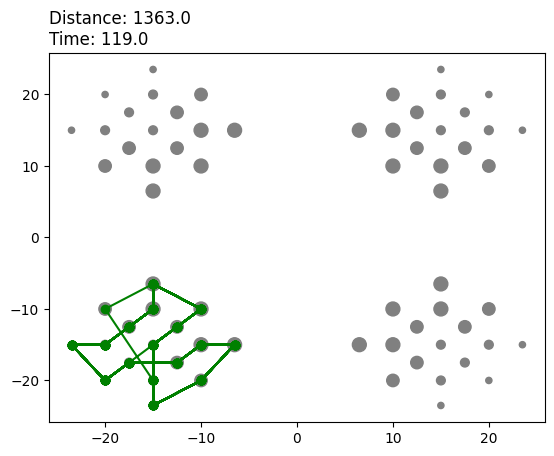

In [92]:
%run ../src/foraging_funs.py
lvl = all_coco_location_data[all_coco_location_data.level == l]

weights = [best_wts.iloc[i] for i in range(3)]

weights.append(1.00)

forage_df = run_foraging_agent(

    lvl_coco_locs=lvl, lvl_dist_m=d[l-1], additive=True, nn=True, ta_min=True, cluster=True,

    weights=weights, rps=[0, .001], clust_neighbors=3
)

# plot path
plt.scatter(lvl.x, lvl.y, s=[i * 20 for i in lvl.point_value], c='grey')


plt.plot(forage_df.x, forage_df.y, marker = 'o', linestyle='-', color='green')
plt.title(
    'Distance: ' + str(round(sum(forage_df.dist), 0)) +
    '\nTime: ' + str(round(np.max(forage_df.time), 0)), loc='left'
)

print(weights)
plt.show()

Text(0.5, 0.92, 'Gradient descent results')

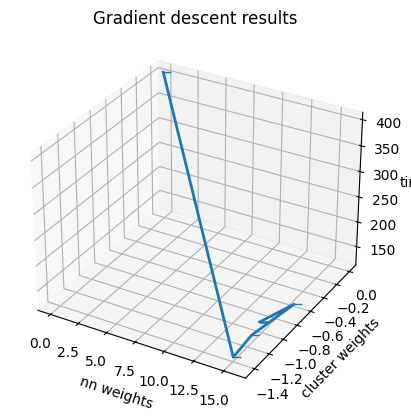

In [93]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(gddf.nn_wts, gddf.clst_wts, gddf.times, linewidth=2, marker=True)
ax.set_xlabel('nn weights')
ax.set_ylabel('cluster weights')
ax.set_zlabel('time')
ax.set_title('Gradient descent results')

In [33]:
gddf.iloc[np.argmin(gddf.times)]

nn_wts               1
clst_wts             1
times       138.941538
Name: 0, dtype: object